In [1]:
import pandas as pd
pd.options.display.max_columns=999
pd.options.display.max_rows=999
from collections import Counter, defaultdict
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%reload_ext autoreload
%autoreload 2
from tqdm import tqdm_notebook, trange
import pickle
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from itertools import chain
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import datetime
import os
from pythainlp import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from fastai.text import *
from fastai.callbacks import CSVLogger, SaveModelCallback
from pythainlp.ulmfit import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from pytorch_wrapper.container import *
from pytorch_wrapper.callback import *
from cto_ds_utilities.tabular_nn import *

In [2]:
review_df = pd.read_csv('src/amzn_fake_review_star_correct_302066.csv')

In [3]:
review_df.head()

,review_id,en_segment,th_segment,correct,review_star
0,1-333090,Good quality product at reasonable price.,สินค้าคุณภาพดีในราคาที่เหมาะสม,1.0,4.0
1,1-57783,They do NOT last more than 10 bottles.,พวกเขาไม่เกิน 10 ขวด,0.0,1.0
2,1-319174,If you like post-apocalyptic fiction with a tw...,ถ้าคุณชอบนิยายหลังเลิกเรียนด้วยการบิดนี่คือมัน,0.0,4.0
3,1-425331,Was a little worried when purchasing due to so...,รู้สึกกังวลเล็กน้อยเมื่อซื้อเนื่องจากรีวิวบางอ...,0.0,4.0
4,1-134583,I had heard from relatives who have read this ...,ฉันได้ยินจากญาติที่อ่านหนังสือเล่มนี้ว่าพ่อแม่...,1.0,2.0


In [4]:
review_df.shape

(302066, 5)

# Explore data

In [5]:
# show random en_segment / th_segment
rand_idx = np.random.randint(len(review_df))
print('Eng comment: {}\n\nThai comment: {}\n\nis_correct: {}\nreview star:{}'\
      .format(review_df.iloc[rand_idx]['en_segment'],
      review_df.iloc[rand_idx]['th_segment'],
      review_df.iloc[rand_idx]['correct'],
      review_df.iloc[rand_idx]['review_star']))

Eng comment: I've been looking for a set of bowls that fit in my cabinet and didn't tip over or spill.I decided on this because it was the largest set.And they work perfectly.They don't slip or feel unstable.But I'm rating them 3 stars instead of 4 due to how cheaply made these are.The glass is thin, which doesn't seem surprising since they're plastic, but still.It isn't like we keep an eye out when we're eating at our table, so there's no reason why it's chipping away from us.

Thai comment: ฉันกำลังมองหาชุดชามที่พอดีในตู้ของฉันและไม่หงายท้องหรือหกฉันตัดสินใจเรื่องนี้เพราะมันเป็นฉากที่ใหญ่ที่สุดและพวกเขาทำงานอย่างสมบูรณ์พวกเขาไม่ลื่นหรือรู้สึกไม่มั่นคงแต่ฉันให้คะแนนพวกเขา 3 ดาวแทนที่จะเป็น 4 เนื่องจากวิธีการทำสิ่งเหล่านี้อย่างถูกกระจกบางซึ่งไม่น่าแปลกใจเพราะมันเป็นพลาสติก แต่ก็ยังมันไม่เหมือนที่เราจับตาดูเมื่อเรากินที่โต๊ะของเราดังนั้นจึงไม่มีเหตุผลว่าทำไมมันถึงบิ่นไปจากเรา

is_correct: 0.0
review star:3.0


In [74]:
review_df.isna().sum()

review_id      0
en_segment     0
th_segment     0
correct        0
review_star    0
dtype: int64

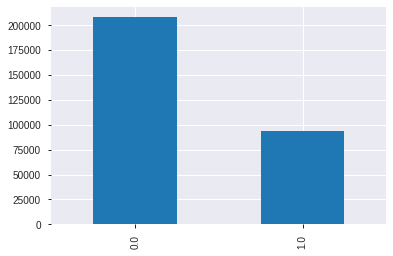

In [75]:
review_df['correct'].value_counts().plot(kind='bar')

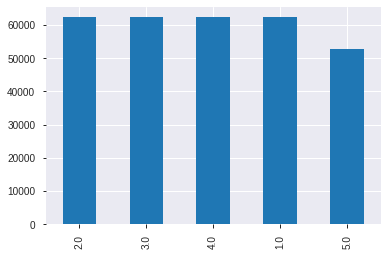

In [76]:
review_df['review_star'].value_counts().plot(kind='bar')

In [77]:
def customized_process_thai(s):
    # pre-rule
    ps = [re.compile(r'\s\.+'),re.compile(r'\s\-+'),re.compile(r'&.*?;')]
    for p in ps: s = p.sub('',s)
    
    # tokenize
    tokens = word_tokenize(s,engine='newmm')
    
    return '|'.join(tokens)

In [12]:
review_df["processed"] = [customized_process_thai(txt) for txt in tqdm_notebook(review_df['th_segment'].values)]
review_df["wc"] = review_df['processed'].map(lambda x: len(x.split("|")))
review_df["uwc"] = review_df['processed'].map(lambda x: len(set(x.split("|"))))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [6]:
# save tokenized review
os.makedirs('tmp',exist_ok=True)
# review_df.to_csv('tmp/review_df_check-point-1.csv',index=False)

review_df = pd.read_csv('tmp/review_df_check-point-1.csv')

In [7]:
review_df.head()

,review_id,en_segment,th_segment,correct,review_star,processed,wc,uwc
0,1-333090,Good quality product at reasonable price.,สินค้าคุณภาพดีในราคาที่เหมาะสม,1.0,4.0,สินค้า|คุณภาพดี|ใน|รา|คาที่|เหมาะสม,6,6
1,1-57783,They do NOT last more than 10 bottles.,พวกเขาไม่เกิน 10 ขวด,0.0,1.0,พวกเขา|ไม่|เกิน| |10| |ขวด,7,6
2,1-319174,If you like post-apocalyptic fiction with a tw...,ถ้าคุณชอบนิยายหลังเลิกเรียนด้วยการบิดนี่คือมัน,0.0,4.0,ถ้า|คุณ|ชอบ|นิยาย|หลัง|เลิกเรียน|ด้วย|การ|บิด|...,12,12
3,1-425331,Was a little worried when purchasing due to so...,รู้สึกกังวลเล็กน้อยเมื่อซื้อเนื่องจากรีวิวบางอ...,0.0,4.0,รู้สึก|กังวล|เล็กน้อย|เมื่อ|ซื้อ|เนื่องจาก|รีว...,10,10
4,1-134583,I had heard from relatives who have read this ...,ฉันได้ยินจากญาติที่อ่านหนังสือเล่มนี้ว่าพ่อแม่...,1.0,2.0,ฉัน|ได้ยิน|จาก|ญาติ|ที่|อ่านหนังสือ|เล่ม|นี้|ว...,17,17


# Train/valid split

In [8]:
train_df, valid_df = train_test_split(review_df, test_size=0.20, random_state=1)
train_df = train_df.reset_index(drop=True)

# further split validation to validation & test
valid_df, test_df = train_test_split(valid_df, test_size=0.50, random_state=11)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.shape, valid_df.shape, test_df.shape

((241652, 8), (30207, 8), (30207, 8))

In [9]:
# prevalence
train_df["correct"].value_counts(normalize=True)

0.0    0.689533
1.0    0.310467
Name: correct, dtype: float64

In [10]:
# prevalence
valid_df["correct"].value_counts(normalize=True)

0.0    0.682822
1.0    0.317178
Name: correct, dtype: float64

Save train/valid/test set

In [11]:
# train_df.to_csv('src/amazon_train.csv',index=False)
# valid_df.to_csv('src/amazon_valid.csv',index=False)
# test_df.to_csv('src/amazon_test.csv',index=False)

train_df = pd.read_csv('src/amazon_train.csv')
valid_df = pd.read_csv('src/amazon_valid.csv')
test_df = pd.read_csv('src/amazon_test.csv')

In [12]:
# create separate train + valid data called all df
all_df = pd.concat([train_df,valid_df],axis=0)
all_df.reset_index(drop=True, inplace=True)

In [13]:
all_df.shape

(271859, 8)

In [14]:
all_df.head()

,review_id,en_segment,th_segment,correct,review_star,processed,wc,uwc
0,1-105256,The writing seems stilted and the characters a...,ดูเหมือนว่าการเขียนจะโอ้อวดและตัวละครไม่น่าสนใ...,0.0,2.0,ดูเหมือนว่า|การเขียน|จะ|โอ้อวด|และ|ตัวละคร|ไม่...,88,69
1,2-38709,We bought these for our 3 year old son to acco...,เราซื้อสิ่งเหล่านี้ให้กับลูกชายวัย 3 ขวบของเรา...,0.0,4.0,เรา|ซื้อ|สิ่ง|เหล่านี้|ให้|กับ|ลูกชาย|วัย| |3|...,43,33
2,1-399475,"this movie was fun and funny, I loved it from ...",หนังเรื่องนี้สนุกและตลกมากฉันชอบมันตั้งแต่ต้นจ...,0.0,4.0,หนัง|เรื่อง|นี้|สนุก|และ|ตลก|มาก|ฉัน|ชอบ|มัน|ต...,24,23
3,2-31276,"The book has a lot of helpful tips, but is lac...",หนังสือเล่มนี้มีเคล็ดลับที่เป็นประโยชน์มากมาย ...,0.0,2.0,หนังสือ|เล่ม|นี้|มี|เคล็ดลับ|ที่|เป็นประโยชน์|...,77,65
4,2-11047,I like the author however this book did was no...,ฉันชอบผู้แต่ง แต่หนังสือเล่มนี้ไม่ได้ขึ้นอยู่ก...,0.0,1.0,ฉัน|ชอบ|ผู้แต่ง| |แต่|หนังสือ|เล่ม|นี้|ไม่|ได้...,42,35


# Preprocess data

## Text feature

In [88]:
# select vocabs with given minimum freq
def get_tokens_from_processed_text(df_col:pd.Series):
    return [toks_str.split('|') for toks_str in df_col.values.tolist()]

tokens_train = get_tokens_from_processed_text(train_df['processed'])
tokens_valid = get_tokens_from_processed_text(valid_df['processed'])
tokens_test = get_tokens_from_processed_text(test_df['processed'])

mcn = Counter(chain(*tokens_train)).most_common()
freq = np.array(list(zip(*mcn))[1])
cut_idx = len(freq[freq>2])
vocabs = list(zip(*mcn))[0][:cut_idx]

In [89]:
# create encoder/decoder for vocabs --> start at 1 and leave 0 for padding and 1 for unknnown
stoi = defaultdict(lambda:1 ,{vocab:i for i,vocab in enumerate(vocabs,2)})
itos = defaultdict(lambda:1 ,{i:vocab for i,vocab in enumerate(vocabs,2)})

In [90]:
# filter tokens
def filter_tokens(tokens, vocabs):
    return [[tkn for tkn in tkns if tkn in vocabs] for tkns in tqdm_notebook(tokens)]

tokens_train = filter_tokens(tokens_train,vocabs)
tokens_valid = filter_tokens(tokens_valid,vocabs)
tokens_test = filter_tokens(tokens_test,vocabs)

def encode_tokens(tokens, stoi):
    return [[stoi[tkn] for tkn in tkns] for tkns in tokens]

# encode tokens
tokens_train_enc = encode_tokens(tokens_train,stoi)
tokens_valid_enc = encode_tokens(tokens_valid,stoi)
tokens_test_enc = encode_tokens(tokens_test,stoi)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


array([34., 63., 84.])

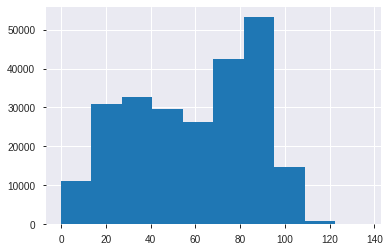

In [91]:
# check tokens length
tokens_len = np.array([len(tokens) for tokens in tokens_train])
_ = plt.hist(tokens_len)
np.percentile(tokens_len, [25,50,75])

In [92]:
def zero_padding(enc_tokens,seq_length):
    '''
    function as written in in https://github.com/udacity/deep-learning-v2-pytorch/blob/master/sentiment-rnn/Sentiment_RNN_Solution.ipynb
    '''
    features = np.zeros((len(enc_tokens),seq_length),dtype=int)
    
    for i, toks in enumerate(enc_tokens):
        if len(toks)>0: features[i, -len(toks):] = np.array(toks)[:seq_length]
        
    return features

# zero padding
text_feat_train = zero_padding(tokens_train_enc, 100)
text_feat_valid = zero_padding(tokens_valid_enc, 100)
text_feat_test = zero_padding(tokens_test_enc, 100)

In [93]:
text_feat_train.shape, text_feat_valid.shape, text_feat_test.shape

((241652, 100), (30207, 100), (30207, 100))

## Numerical feature

In [17]:
# get numeric feat --> just use the original word count & unique word count
scaler = StandardScaler()
num_cols = ['wc','uwc']
num_feat_train = scaler.fit_transform(train_df[num_cols].values)
num_feat_valid = scaler.transform(valid_df[num_cols].values)
num_feat_test = scaler.transform(test_df[num_cols].values)

In [18]:
num_feat_train.shape, num_feat_valid.shape, num_feat_test.shape

((241652, 2), (30207, 2), (30207, 2))

## Targets

In [19]:
targ1_col = 'correct'
targ1_train = train_df[targ1_col].values
targ1_valid = valid_df[targ1_col].values
targ1_test = test_df[targ1_col].values

targ2_col = 'review_star'
label_enc = LabelEncoder()

targ2_train = label_enc.fit_transform(train_df[targ2_col].values)
targ2_valid = label_enc.transform(valid_df[targ2_col].values)
targ2_test = label_enc.transform(test_df[targ2_col].values)

Check-point

In [21]:
# pickle.dump(text_feat_train,open('tmp/text_feat_train.pkl','wb'))
# pickle.dump(text_feat_valid,open('tmp/text_feat_valid.pkl','wb'))
# pickle.dump(text_feat_test,open('tmp/text_feat_test.pkl','wb'))

# pickle.dump(num_feat_train,open('tmp/num_feat_train.pkl','wb'))
# pickle.dump(num_feat_valid,open('tmp/num_feat_valid.pkl','wb'))
# pickle.dump(num_feat_test,open('tmp/num_feat_test.pkl','wb'))

# pickle.dump(targ1_train,open('tmp/targ1_train.pkl','wb'))
# pickle.dump(targ1_valid,open('tmp/targ1_valid.pkl','wb'))
# pickle.dump(targ1_test,open('tmp/targ1_test.pkl','wb'))

# pickle.dump(targ2_train,open('tmp/targ2_train.pkl','wb'))
# pickle.dump(targ2_valid,open('tmp/targ2_valid.pkl','wb'))
# pickle.dump(targ2_test,open('tmp/targ2_test.pkl','wb'))

# pickle.dump(vocabs,open('tmp/vocab.pkl','wb'))

# text_feat_train = pickle.load(open('tmp/text_feat_train.pkl','rb'))
# text_feat_valid = pickle.load(open('tmp/text_feat_valid.pkl','rb'))
# text_feat_test = pickle.load(open('tmp/text_feat_test.pkl','rb'))

# num_feat_train = pickle.load(open('tmp/num_feat_train.pkl','rb'))
# num_feat_valid = pickle.load(open('tmp/num_feat_valid.pkl','rb'))
# num_feat_test = pickle.load(open('tmp/num_feat_test.pkl','rb'))

# targ1_train = pickle.load(open('tmp/targ1_train.pkl','rb'))
# targ1_valid = pickle.load(open('tmp/targ1_valid.pkl','rb'))
# targ1_test = pickle.load(open('tmp/targ1_test.pkl','rb'))

# targ2_train = pickle.load(open('tmp/targ2_train.pkl','rb'))
# targ2_valid = pickle.load(open('tmp/targ2_valid.pkl','rb'))
# targ2_test = pickle.load(open('tmp/targ2_test.pkl','rb'))

# vocabs = pickle.load(open('tmp/vocab.pkl','rb'))

# Model

## Logistic regression

In [23]:
tfidf = TfidfVectorizer(tokenizer=lambda x:x.split('|'), ngram_range=(1,2), max_features=25_000, sublinear_tf=True)
tfidf.fit(all_df["processed"])
text_train = tfidf.transform(train_df["processed"])
text_valid = tfidf.transform(valid_df["processed"])
text_test = tfidf.transform(test_df["processed"])
text_train.shape, text_valid.shape

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=25000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function <lambda> at 0x12c45a598>, use_idf=True,
                vocabulary=None)

((241652, 25000), (30207, 25000))

In [24]:
#concatenate text and word count features
X_train = np.concatenate([num_feat_train,text_train.toarray()],axis=1)
X_valid = np.concatenate([num_feat_valid,text_valid.toarray()],axis=1)
X_test = np.concatenate([num_feat_test,text_test.toarray()],axis=1)
X_train.shape, X_valid.shape

((241652, 25002), (30207, 25002))

### Train on training data only

In [26]:
#fit logistic regression models
model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_train,targ1_train)
model.score(X_valid,targ1_valid)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

0.7077167543946767

In [27]:
#fit logistic regression models
model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_train,targ2_train)
model.score(X_valid,targ2_valid)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

0.5977422451749594

### Training on training + validation data

In [29]:
X_all = np.concatenate([X_train,X_valid],0)
targ1_all = np.concatenate([targ1_train,targ1_valid],0)
targ2_all = np.concatenate([targ2_train,targ2_valid],0)

In [30]:
#fit logistic regression models
model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_all,targ1_all)
model.score(X_test,targ1_test)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

0.713344589002549

In [33]:
#fit logistic regression models
model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_all,targ2_all)
model.score(X_test,targ2_test)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

0.596153209520972

## ULMFit

In [9]:
os.makedirs('output', exist_ok=True)
model_path = "output/"

In [46]:
tt = Tokenizer(tok_func=ThaiTokenizer, lang="th", pre_rules=pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10_000, mark_fields=False),
            NumericalizeProcessor(vocab=None, max_vocab=30_000, min_freq=2)]

data_lm = (TextList.from_df(all_df, model_path, cols="th_segment", processor=processor)
    .split_by_rand_pct(valid_pct = 0.01, seed = 1412)
    .label_for_lm()
    .databunch(bs=128))
data_lm.sanity_check()

In [47]:
data_lm.save('amazon_fake_review_lm.pkl')

In [48]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=1., clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args)

#load pretrained models
learn.load_pretrained(**_THWIKI_LSTM)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (269141 items)
x: LMTextList
xxbos   ดูเหมือนว่า การเขียน จะ โอ้อวด และ ตัวละคร ไม่ น่าสนใจ พอ ที่จะ ดึง ฉัน เข้ามา มี หลาย คน ที่ เป็น แบบแผน เช่น   &' nerd &'   หรือ   &' jerk &' และ พล็อต เรื่อง ต่าง   ๆ   ดูเหมือน จะ ถูก วางแผน เพื่อ ความ สะดวกสบาย ของ ฉัน เรื่องราว ลาก ไป ใน สถานที่ โดยเฉพาะอย่างยิ่ง ใน บางครั้ง อาจ เป็น เพราะ ฉัน เคยชิน กับ นวนิยาย อเมริกัน สมัยใหม่ ซึ่ง มีแนวโน้ม ที่จะ เคลื่อนไหว ได้ เร็ว ขึ้น โดย ไม่ต้อง สร้าง โลก ที่ ซับซ้อน ในทางกลับกัน ตัวละคร เหล่านี้ มี ความลึก ไม่ มาก เมื่อ เทียบ กับ ที่ ฉัน มักจะ พบ   /   พบ เจอ,xxbos   เรา ซื้อ สิ่ง เหล่านี้ ให้ กับ ลูกชาย วัย   3   ขวบ ของ เรา เพื่อ ติดตาม   kindle   fire   ใหม่ ของ เขา เพราะ เรา คิด ว่า เขา จะ กลัว ที่จะ ใช้ มัน   แต่ พวกเขา กลับ กลายเป็น ว่า ถูกต้อง ง่าย นิดเดียว,xxbos   หนัง เรื่อง นี้ สนุก และ ตลก มาก ฉัน ชอบ มัน ตั้ง แต่ต้นจนจบ ภาพยนตร์ คืน วันที่ ดี เหมาะสำหรับ ผู้ ที่ ไม่ ชอบ อารมณ์ขัน หรือ ความรุนแรง,xxbos   หนังสือ เล่ม นี้ มี เคล็ดลับ ที

In [49]:
print("training frozen")
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

training frozen


epoch,train_loss,valid_loss,accuracy,time
0,4.079043,3.842914,0.288828,18:16


In [50]:
#train unfrozen
print("training unfrozen")
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, moms=(0.8, 0.7))

training unfrozen


epoch,train_loss,valid_loss,accuracy,time
0,3.747461,3.570154,0.323326,18:31
1,3.581792,3.424643,0.340161,18:29
2,3.498412,3.353867,0.348631,18:29
3,3.437457,3.317187,0.352902,18:31
4,3.409792,3.308141,0.354065,18:31


In [51]:
learn.save_encoder("amazon_thai_review_enc")

### Train classifier

#### Task 1

In [ ]:
# convert target to int for fastai to understand training task as classification
all_df['correct'] = all_df['correct'].astype(int)

#lm data
data_lm = load_data(model_path, 'amazon_fake_review_lm.pkl')
data_lm.sanity_check()

#classification data
tt = Tokenizer(tok_func=ThaiTokenizer, lang="th", pre_rules=pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=data_lm.vocab, max_vocab=30_000, min_freq=2)]

data_cls = (ItemLists(model_path,train=TextList.from_df(all_df, model_path, cols=["th_segment"], processor=processor),
                     valid=TextList.from_df(valid_df, model_path, cols=["th_segment"], processor=processor))
    .label_from_df("correct")
    .databunch(bs=256)
    )
data_cls.sanity_check()
print(len(data_cls.vocab.itos))

In [11]:
#model
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
             output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
trn_args = dict(bptt=70, drop_mult=0.7, alpha=2, beta=1, max_len=500)

learn = text_classifier_learner(data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)
#load pretrained finetuned model
learn.load_encoder("amazon_thai_review_enc")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (271859 items)
x: TextList
xxbos   ดูเหมือนว่า การเขียน จะ โอ้อวด และ ตัวละคร ไม่ น่าสนใจ พอ ที่จะ ดึง ฉัน เข้ามา มี หลาย คน ที่ เป็น แบบแผน เช่น   &' nerd &'   หรือ   &' jerk &' และ พล็อต เรื่อง ต่าง   ๆ   ดูเหมือน จะ ถูก วางแผน เพื่อ ความ สะดวกสบาย ของ ฉัน เรื่องราว ลาก ไป ใน สถานที่ โดยเฉพาะอย่างยิ่ง ใน บางครั้ง อาจ เป็น เพราะ ฉัน เคยชิน กับ นวนิยาย อเมริกัน สมัยใหม่ ซึ่ง มีแนวโน้ม ที่จะ เคลื่อนไหว ได้ เร็ว ขึ้น โดย ไม่ต้อง สร้าง โลก ที่ ซับซ้อน ในทางกลับกัน ตัวละคร เหล่านี้ มี ความลึก ไม่ มาก เมื่อ เทียบ กับ ที่ ฉัน มักจะ พบ   /   พบ เจอ,xxbos   เรา ซื้อ สิ่ง เหล่านี้ ให้ กับ ลูกชาย วัย   3   ขวบ ของ เรา เพื่อ ติดตาม   kindle   fire   ใหม่ ของ เขา เพราะ เรา คิด ว่า เขา จะ กลัว ที่จะ ใช้ มัน   แต่ พวกเขา กลับ กลายเป็น ว่า ถูกต้อง ง่าย นิดเดียว,xxbos   หนัง เรื่อง นี้ สนุก และ ตลก มาก ฉัน ชอบ มัน ตั้ง แต่ต้นจนจบ ภาพยนตร์ คืน วันที่ ดี เหมาะสำหรับ ผู้ ที่ ไม่ ชอบ อารมณ์ขัน หรือ ความรุนแรง,xxbos   หนังสือ เล่ม นี้ มี เคล็ดลับ ที่ เป็

In [12]:
learn.freeze_to(-1)
learn.fit_one_cycle(1, 2e-2)

learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(2e-6 / (2.6 ** 4), 2e-6))

learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-6 / (2.6 ** 4), 1e-6))

learn.unfreeze()
learn.fit_one_cycle(3, slice(5e-7 / (2.6 ** 4), 5e-7),
                   callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='bestmodel')])

epoch,train_loss,valid_loss,accuracy,time
0,0.615187,0.585522,0.701592,16:49


epoch,train_loss,valid_loss,accuracy,time
0,0.604787,0.585467,0.701725,16:55


epoch,train_loss,valid_loss,accuracy,time
0,0.588029,0.587631,0.707121,15:11


epoch,train_loss,valid_loss,accuracy,time
0,0.612046,0.585743,0.700235,17:02
1,0.607746,0.585793,0.701957,15:51
2,0.603214,0.586834,0.706823,14:43


Better model found at epoch 0 with accuracy value: 0.7002350687980652.
Better model found at epoch 1 with accuracy value: 0.7019565105438232.
Better model found at epoch 2 with accuracy value: 0.70682293176651.


In [13]:
learn.save_encoder("amazon_thai_review_enc-clf1")

In [16]:
learn.export(file='export_clas1.pkl')
test_df['correct'] = test_df['correct'].astype(int)
learn_ = load_learner(model_path,file='export_clas1.pkl',test=TextList.from_df(test_df, model_path, cols=["th_segment"], processor=processor))
preds, _ = learn_.get_preds(ds_type=DatasetType.Test)

In [49]:
(preds.argmax(1).numpy() == test_df['correct'].values).mean()

0.7095375244148707

#### Task 2

In [52]:
# convert target to int for fastai to understand training task as classification
all_df['review_star'] = all_df['review_star'].astype(int)

#lm data
data_lm = load_data(model_path, "amazon_fake_review_lm.pkl")
data_lm.sanity_check()

#classification data
tt = Tokenizer(tok_func=ThaiTokenizer, lang="th", pre_rules=pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=data_lm.vocab, max_vocab=30_000, min_freq=2)]

#classification data
data_cls = (ItemLists(model_path,train=TextList.from_df(all_df, model_path, cols=["th_segment"], processor=processor),
                     valid=TextList.from_df(valid_df, model_path, cols=["th_segment"], processor=processor))
    .label_from_df("review_star")
    .databunch(bs=256)
    )
data_cls.sanity_check()
print(len(data_cls.vocab.itos))

27720


In [53]:
#model
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
             output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
trn_args = dict(bptt=70, drop_mult=0.7, alpha=2, beta=1, max_len=500)

learn = text_classifier_learner(data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)
#load pretrained finetuned model
learn.load_encoder("amazon_thai_review_enc")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (271859 items)
x: TextList
xxbos   ดูเหมือนว่า การเขียน จะ โอ้อวด และ ตัวละคร ไม่ น่าสนใจ พอ ที่จะ ดึง ฉัน เข้ามา มี หลาย คน ที่ เป็น แบบแผน เช่น   &' nerd &'   หรือ   &' jerk &' และ พล็อต เรื่อง ต่าง   ๆ   ดูเหมือน จะ ถูก วางแผน เพื่อ ความ สะดวกสบาย ของ ฉัน เรื่องราว ลาก ไป ใน สถานที่ โดยเฉพาะอย่างยิ่ง ใน บางครั้ง อาจ เป็น เพราะ ฉัน เคยชิน กับ นวนิยาย อเมริกัน สมัยใหม่ ซึ่ง มีแนวโน้ม ที่จะ เคลื่อนไหว ได้ เร็ว ขึ้น โดย ไม่ต้อง สร้าง โลก ที่ ซับซ้อน ในทางกลับกัน ตัวละคร เหล่านี้ มี ความลึก ไม่ มาก เมื่อ เทียบ กับ ที่ ฉัน มักจะ พบ   /   พบ เจอ,xxbos   เรา ซื้อ สิ่ง เหล่านี้ ให้ กับ ลูกชาย วัย   3   ขวบ ของ เรา เพื่อ ติดตาม   kindle   fire   ใหม่ ของ เขา เพราะ เรา คิด ว่า เขา จะ กลัว ที่จะ ใช้ มัน   แต่ พวกเขา กลับ กลายเป็น ว่า ถูกต้อง ง่าย นิดเดียว,xxbos   หนัง เรื่อง นี้ สนุก และ ตลก มาก ฉัน ชอบ มัน ตั้ง แต่ต้นจนจบ ภาพยนตร์ คืน วันที่ ดี เหมาะสำหรับ ผู้ ที่ ไม่ ชอบ อารมณ์ขัน หรือ ความรุนแรง,xxbos   หนังสือ เล่ม นี้ มี เคล็ดลับ ที่ เป็

In [54]:
learn.freeze_to(-1)
learn.fit_one_cycle(1, 2e-2)

learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(2e-6 / (2.6 ** 4), 2e-6))

learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-6 / (2.6 ** 4), 1e-6))

learn.unfreeze()
learn.fit_one_cycle(3, slice(5e-7 / (2.6 ** 4), 5e-7),
                   callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='bestmodel')])

epoch,train_loss,valid_loss,accuracy,time
0,1.154384,1.057550,0.539974,14:42


epoch,train_loss,valid_loss,accuracy,time
0,1.139452,1.054968,0.542755,15:13


epoch,train_loss,valid_loss,accuracy,time
0,1.151406,1.052472,0.543185,14:36


epoch,train_loss,valid_loss,accuracy,time
0,1.140140,1.055715,0.541927,17:40
1,1.136665,1.053820,0.542391,17:25
2,1.132597,1.054545,0.541894,16:13


Better model found at epoch 0 with accuracy value: 0.5419273972511292.
Better model found at epoch 1 with accuracy value: 0.5423908233642578.


In [55]:
learn.export(file='export_clas2.pkl')
test_df['review_star'] = test_df['review_star'].astype(int)
learn_ = load_learner(model_path,file='export_clas2.pkl',test=TextList.from_df(test_df, model_path, cols=["th_segment"], processor=processor))
preds, _ = learn_.get_preds(ds_type=DatasetType.Test)

In [67]:
(np.array([label_enc.classes_[c] for c in preds.argmax(1).numpy()])== test_df['review_star'].values).mean()

0.5355050153937829

## Customised RNN based model

In [11]:
# input dtypes: text -> long, numeric -> double
in_dtypes = [torch.long, torch.double]
# output dtypes: binary classification targ -> double (as probability), n class classification targ -> long
targ_dtypes = [torch.double, torch.long]

train_ds = UniversalDataset(ins=[text_feat_train, num_feat_train],
              in_dtypes=in_dtypes,
              targs=[targ1_train[:,None], targ2_train],
              targ_dtypes=targ_dtypes)

valid_ds = UniversalDataset(ins=[text_feat_valid, num_feat_valid],
                           in_dtypes=in_dtypes,
                           targs=[targ1_valid[:,None], targ2_valid],
                           targ_dtypes=targ_dtypes)

test_ds = UniversalDataset(ins=[text_feat_test, num_feat_test],
                          in_dtypes=in_dtypes,
                          targs = [targ1_test[:,None], targ2_test],
                          targ_dtypes = targ_dtypes)

bs = 256
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False)

data_train = DataBunch(train_dl, valid_dl)

In [13]:
# stack train & valid data then retrain on whole data
all_ds = ConcatDataset([train_ds,valid_ds])
all_dl = DataLoader(all_ds,batch_size=bs, shuffle=True)
# all_dl_ = DataLoader(all_ds,batch_size=bs, shuffle = False)
data_all = DataBunch(all_dl, None)

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        # Inspired by the implementation of binary_cross_entropy_with_logits
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

        # This formula gives us the log sigmoid of 1-p if y is 0 and of p if y is 1
        invprobs = F.logsigmoid(-input * (target * 2 - 1))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

def accuracy_binary(out, yb): return ((torch.sigmoid(out)>.5).float()==yb).float().mean()

def accuracy_categorical(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [15]:
loss_func1 = FocalLoss(gamma=.5)
loss_func2 = nn.CrossEntropyLoss()

multi_loss_func = MultitasksLoss([loss_func1, loss_func2])

In [16]:
metric1 = accuracy_binary
metric2 = accuracy_categorical

In [18]:
class Attention(nn.Module):
    # borrow from: https://github.com/mttk/rnn-classifier/blob/master/model.py
    
    def __init__(self, query_dim, key_dim, value_dim):
        super(Attention, self).__init__()
        self.scale = 1. / math.sqrt(query_dim)

    def forward(self, query, keys, values):
        # Query = [BxQ]
        # Keys = [TxBxK]
        # Values = [TxBxV]
        # Outputs = a:[TxB], lin_comb:[BxV]

        # Here we assume q_dim == k_dim (dot product attention)

        query = query.unsqueeze(1) # [BxQ] -> [Bx1xQ]
        keys = keys.transpose(-1,1)
        energy = torch.bmm(query, keys) # [Bx1xQ]x[BxKxT] -> [Bx1xT]
        energy = F.softmax(energy.mul_(self.scale), dim=2) # scale, normalize
        
        linear_combination = torch.bmm(energy, values).squeeze(1) #[Bx1xT]x[BxTxV] -> [BxV]
        
        return energy, linear_combination

class AmazonMultiTaskAttn(nn.Module):

    def __init__(self, **config):
        super(AmazonMultiTaskAttn, self).__init__()

        # store config
        self.config = config
        # store current device
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        # numerical feat projector
        self.num_proj = nn.Sequential(nn.Linear(config['n_num'],config['num_dim']),
                                      nn.BatchNorm1d(config['num_dim'])
                                     )
        
        # embedding layers
        self.word_emb = nn.Embedding(config['vocab_size'] + 2, config['emb_size'])

        # rnn layers
        self.rnn = nn.GRU(input_size=config['emb_size'], hidden_size=config['rnn_h'],
                           num_layers=config['rnn_l'], batch_first=True, bidirectional=True)

        # self-attention
        self.attention = Attention(config['rnn_h']*2,config['rnn_h']*2,config['rnn_h']*2)
        
        # fc layers
        self.lin_in = config['num_dim'] + config['rnn_h'] * 2
        self.fc_sizes = [self.lin_in] + config['fc_sizes']

        fc_layers_list = []
        for ni, nf, p in zip(self.fc_sizes[:-1], self.fc_sizes[1:], config['fc_ps']):
            fc_layers_list.append(nn.Linear(ni, nf))
            fc_layers_list.append(nn.ReLU(inplace=True))
            fc_layers_list.append(nn.BatchNorm1d(nf))
            fc_layers_list.append(nn.Dropout(p=p))
        self.fc_layers = nn.Sequential(*fc_layers_list)

        # output heads by task
        self.heads = nn.ModuleList([nn.Linear(self.fc_sizes[-1], out_size) for out_size in config['out_sizes']])
        
    def forward(self, ins):
        text, num = ins
        text, num = text.to(self.device), num.to(self.device)

        # numeric
        num_out = self.num_proj(num)
        
        # text
        text_out = self.word_emb(text)
        rnn_outs, rnn_hidden = self.rnn(text_out)
        rnn_hidden = torch.cat([rnn_hidden[-1], rnn_hidden[-2]], dim=1)
        energy, text_out = self.attention(rnn_hidden, rnn_outs, rnn_outs)

        # concat
        lin_in = torch.cat([text_out, num_out], 1)

        # fc forward
        fc_out = self.fc_layers(lin_in)
        head_outs = [head(fc_out) for head in self.heads]

        return head_outs

In [119]:
config = {'vocab_size': len(vocabs),'emb_size': 400, 'rnn_h': 300,
        'rnn_l': 2, 'fc_ps': [0.5, 0.5], 'n_num':2, 'num_dim':100 , 'fc_sizes': [1000, 500], 'out_sizes': [1,5]}

model = AmazonMultiTaskAttn(**config).double()

In [120]:
_ = model.to(model.device)

In [121]:
# test model with data
model(next(iter(train_dl))[0])[0].shape, model(next(iter(train_dl))[0])[1].shape

(torch.Size([256, 1]), torch.Size([256, 5]))

In [122]:
config = {'vocab_size': len(vocabs),'emb_size': 400, 'rnn_h': 300,
        'rnn_l': 2, 'fc_ps': [0.5, 0.5], 'n_num':2, 'num_dim':100 , 'fc_sizes': [1000, 500], 'out_sizes': [1,5]}

model = AmazonMultiTaskAttn(**config).double()
_ = model.to(model.device)

multi_loss_func = MultitasksLoss([loss_func1, loss_func2],loss_weights=[.6,.4])
opt = optim.Adam(model.parameters(),lr=1e-3)

learner = Learner(model=model, data=data_train, loss_func=multi_loss_func, optimizer=opt, cbfs=cbfs)

cbfs = [partial(AvgStatsCallback,[metric1, metric2])]

max_lr=1e-3
sched_lr = combine_scheds([0.3, 0.7], [sched_cos(max_lr/5,max_lr),sched_cos(max_lr,max_lr/10)])
sched_beta1 = combine_scheds([0.3, 0.7], [sched_cos(0.9, 0.8), sched_cos(0.8, 0.9)])
sched_beta2 = combine_scheds([0.3, 0.7], [sched_cos(0.99, 0.9), sched_cos(0.9, 0.99)])
def sched_betas(pos): return [sched_beta1(pos), sched_beta2(pos)]

sched_dict = {'lr':sched_lr, 'betas': sched_betas}
learner.fit_with_sched(3,sched_dict)

epoch 1-train: [0.7433645853325621, tensor(0.6780, device='cuda:0'), tensor(0.4761, device='cuda:0')]
epoch 1-valid: [0.6592615903416682, tensor(0.7061, device='cuda:0'), tensor(0.5489, device='cuda:0')]
epoch 2-train: [0.6238996603507941, tensor(0.7160, device='cuda:0'), tensor(0.5906, device='cuda:0')]
epoch 2-valid: [0.6139034271199542, tensor(0.7136, device='cuda:0'), tensor(0.6032, device='cuda:0')]
epoch 3-train: [0.5431565020957869, tensor(0.7300, device='cuda:0'), tensor(0.6794, device='cuda:0')]
epoch 3-valid: [0.5989208946867739, tensor(0.7164, device='cuda:0'), tensor(0.6351, device='cuda:0')]


### Train with all data

In [19]:
config = {'vocab_size': len(vocabs),'emb_size': 400, 'rnn_h': 300,
        'rnn_l': 2, 'fc_ps': [0.5, 0.5], 'n_num':2, 'num_dim':100 , 'fc_sizes': [1000, 500], 'out_sizes': [1,5]}

model = AmazonMultiTaskAttn(**config).double()
_ = model.to(model.device)

multi_loss_func = MultitasksLoss([loss_func1, loss_func2],loss_weights=[.6,.4])
opt = optim.Adam(model.parameters(),lr=1e-3)

cbfs = [partial(AvgStatsCallback,[metric1, metric2])]

learner = Learner(model=model, data=data_all, loss_func=multi_loss_func, optimizer=opt, cbfs=cbfs)

max_lr=1e-3
sched_lr = combine_scheds([0.3, 0.7], [sched_cos(max_lr/5,max_lr),sched_cos(max_lr,max_lr/10)])
sched_beta1 = combine_scheds([0.3, 0.7], [sched_cos(0.9, 0.8), sched_cos(0.8, 0.9)])
sched_beta2 = combine_scheds([0.3, 0.7], [sched_cos(0.99, 0.9), sched_cos(0.9, 0.99)])
def sched_betas(pos): return [sched_beta1(pos), sched_beta2(pos)]

sched_dict = {'lr':sched_lr, 'betas': sched_betas}
learner.fit_with_sched(3,sched_dict)

epoch 1-train: [0.7380565785069271, tensor(0.6797, device='cuda:0'), tensor(0.4823, device='cuda:0')]
epoch 2-train: [0.6197548010921846, tensor(0.7161, device='cuda:0'), tensor(0.5955, device='cuda:0')]
epoch 3-train: [0.5362411390583282, tensor(0.7308, device='cuda:0'), tensor(0.6870, device='cuda:0')]


Get test accuracy

In [52]:
_ = model.eval()

count = 0
tot_mets = [0., 0.]
metrics = [metric1, metric2]
with torch.no_grad():
    for xb,yb in test_dl:
        pred = model(xb)
        bn = yb[0].shape[0]
        count += bn
        for i,m in enumerate(metrics):
            tot_mets[i] += m(pred[i], yb[i].to(model.device)).item() * bn
            
avg_stats = [met/count for met in tot_mets]

In [53]:
avg_stats

[0.7212566625110189, 0.6430628664006495]

# Summary

**model** | **task 1: predicting readable review accuracy** | **task 2: predicting review star**
--|--|--
Logistic regression | 71.33% | 59.61%
ULMFit| 70.95%| 53.55%
Bi-GRU + Attention + Multi-tasking| **72.12%** | **64.30%**